# **Install Liberary**

In [1]:
# !pip install torchmetrics
!pip install -U torchsummary
# !pip install -U torch
# !pip install torchvision  -U
# !pip install -U Pillow
# !pip install -U seaborn
# !pip install patool

In [2]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 2.5 MB/s eta 0:00:0000:0100:01


In [3]:
# pip install Cython

In [4]:
# pip install torch==1.7

In [5]:
# pip install --upgrade torch torchvision

# **Import Librarys**

In [6]:
# PyTorch
import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch import cuda, optim
from torch.utils.data import DataLoader, sampler
from torch.utils.data import random_split
from torchmetrics import ConfusionMatrix
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from IPython.display import clear_output
from torch.utils.data import Subset
warnings.filterwarnings("ignore", category=FutureWarning)

import os

# Timing utility
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt

# Data science tools
import numpy as np
import pandas as pd
import seaborn as sns

# Useful for examining network
from torchsummary import summary

import warnings

from IPython.display import clear_output

warnings.filterwarnings("ignore")

train_on_gpu = cuda.is_available()

%matplotlib inline

In [7]:
# import timm
from timm.loss import LabelSmoothingCrossEntropy # This is better than normal nn.CrossEntropyLoss

In [8]:
# Prepare your dataset here
# import patoolib
# patoolib.extract_archive("Mel128_5000_M_P_35000.rar", outdir="C:/Users/user")

# Initialize the model and dataset

In [9]:
model_Type='vgg16'
feature= 'Mel128'  
RandomState = 42

In [10]:
PathToDF = "VGG16_Model.csv"
DataSetName = f"{feature}_50000_M_P12088"

rd = np.random.randint(100000)
modelName = f"{model_Type}_{DataSetName}_{rd}"

In [11]:
if not os.path.exists(modelName):
    os.mkdir(modelName)
    os.mkdir(f"{modelName}/model")

# Functions

In [12]:
def Save_To_CSV(PathToDF, df):
    if os.path.exists(PathToDF):
        df.to_csv(PathToDF, mode="a", header=False)
    else:
        df.to_csv(PathToDF)

In [13]:
def test(model, test_loader, criterion, CM=False):
    with torch.no_grad():
        model.eval()
        test_acc = 0
        preidcted = np.array([])
        ALL_Labels = np.array([])

        confusionMatrix = np.zeros((7, 7))
        for images, labels in test_loader:

            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            _, pred = torch.max(outputs, dim=1)
            correct_tensor = pred.eq(labels.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            test_acc += accuracy.item() * images.size(0)
            if CM:
                preidcted = np.append(preidcted, pred.to("cpu").numpy())
                ALL_Labels = np.append(ALL_Labels, labels.to("cpu").numpy())

        test_acc = test_acc / len(test_loader.dataset)

        if CM == True:
            confmat = ConfusionMatrix(task="multiclass", num_classes=7)
            confusionMatrix = np.array(
                confmat(
                    torch.tensor(preidcted.astype("int32")),
                    torch.tensor(ALL_Labels.astype("int32")),
                )
            )

        return test_acc, confusionMatrix

# **Evaluation matrix**

In [14]:
# def evaluate(model, test_loader, criterion):
  
#   classes = []
#   acc_results = np.zeros(len(test_loader.dataset))
#   i = 0

#   model.eval()
#   with torch.no_grad():
#     for images, labels in test_loader:
#       images = images.to(device)
#       labels = labels.to(device)
#       outputs = model(images)
      
#       for pred, true in zip(outputs, labels):
#         _, pred = pred.unsqueeze(0).topk(1)
#         correct = pred.eq(true.unsqueeze(0))
#         acc_results[i] = correct.cpu()
#         classes.append(model.idx_to_class[true.item()])
#         i+=1
  
#   results = pd.DataFrame({
#       'class': classes,
#       'results': acc_results    
#   })
#   results = results.groupby(classes).mean()

#   return results

# Load Data

In [15]:
torch.manual_seed(RandomState)

In [16]:
# transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

# dataset = datasets.ImageFolder(f"../MelSpecImages/MelSpecImages/Mel128_50000_333575", transform=transform)

# dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)


# train_data = int(len(dataset) * 0.8)
# valid_data = int((len(dataset) - train_data) / 2)
# test_data = int(len(dataset) - train_data - valid_data)

# train_set, val_set, test_set = torch.utils.data.random_split(
#     dataset, [train_data, valid_data, test_data]
# )

# train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=20 * 4, pin_memory=True)
# valid_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=True, num_workers=20 * 4, pin_memory=True)
# test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, num_workers=20 * 4, pin_memory=True)

In [17]:
Initial_DF = pd.read_csv("/kaggle/input/splited/Splited_Sampel_Data.csv")

In [18]:
Train_index = Initial_DF[Initial_DF["SetType"]=="train"].index
Test_index = Initial_DF[Initial_DF["SetType"]=="test"].index
Valdi_index = Initial_DF[Initial_DF["SetType"]=="valid"].index

In [19]:
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
dataset = datasets.ImageFolder(f"/kaggle/input/fulldataspecimage/MelSpecImages/Mel128_50000_333575", transform=transform)

train_dataset = Subset(dataset, Train_index)
test_dataset = Subset(dataset, Test_index)
valid_dataset = Subset(dataset, Valdi_index)

In [20]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)

# Train pre trained VGG16

In [21]:
import torchvision.models as models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **VGG16 Class**
```
vgg16 in pytorch
```

In [22]:

class VGG16(nn.Module):
    def __init__(self, num_classes=7):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


In [23]:
num_classes = 7
model = VGG16(num_classes).to(device)

In [24]:
# summary(model, input_size=(3, 224, 224), batch_size=32, device="cuda")

In [25]:
model.class_to_idx = dataset.class_to_idx
model.idx_to_class = {idx: class_ for class_, idx in model.class_to_idx.items()}
list(model.idx_to_class.items())[:7]

[(0, 'ar'), (1, 'de'), (2, 'en'), (3, 'es'), (4, 'fr'), (5, 'it'), (6, 'pt')]

# **Training Data and Validation Data processing**

In [26]:
def train(
    model,
    criterion,
    optimizer,
    train_loader,
    valid_loader,
    save_file_name,
    max_epochs_stop=3,
    n_epochs=20,
    print_every=1,
):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf
    valid_acc_max = 0

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f"Model has been trained for: {model.epochs} epochs.\n")
    except:
        model.epochs = 0
        print(f"Starting Training from Scratch.\n")

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()
        
      

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f"Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.",
                end="\r",
            )
      

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)
                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f"\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}"
                    )
                    print(
                        f"\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%"
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # if valid_acc > valid_acc_max:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_acc_max = valid_acc
                    # valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f"\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc_max:.2f}%"
                        )
                        total_time = timer() - overall_start
                        print(
                            f"{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch."
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                "train_loss",
                                "valid_loss",
                                "train_acc",
                                "valid_acc",
                            ],
                        )
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f"\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%"
    )
    print(
        f"{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch."
    )
    # Format history
    history = pd.DataFrame(
        history, columns=["train_loss", "valid_loss", "train_acc", "valid_acc"]
    )
    return model, history

## optim and loss

In [27]:
num_classes = 7
model = VGG16(num_classes).to(device)
# criterion = nn.CrossEntropyLoss()
criterion = LabelSmoothingCrossEntropy()
# criterion = criterion.to("cuda")
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay = 0.0001, momentum=0.9)
# optimizer = optim.Adam(model.head.parameters(), lr=0.01)

# Train the model
total_step = len(train_loader)

In [28]:
# rd= np.random.randint(100000)
# modelName= f"VGG_{DataSetName}_{rd}"

model, history = train(
    model,
    criterion,
    optimizer,
    train_loader,
    valid_loader,
    save_file_name=f"{modelName}/model/{modelName}.pt",
    max_epochs_stop=3,
    n_epochs=100,
    print_every=1
)

Starting Training from Scratch.

Epoch: 0	100.00% complete. 2214.00 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 1.2376 	Validation Loss: 1.2209
		Training Accuracy: 62.26%	 Validation Accuracy: 66.27%
Epoch: 1	100.00% complete. 2212.62 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.9045 	Validation Loss: 0.9899
		Training Accuracy: 79.73%	 Validation Accuracy: 75.36%
Epoch: 2	100.00% complete. 2211.40 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 0.7920 	Validation Loss: 0.8948
		Training Accuracy: 84.90%	 Validation Accuracy: 79.76%
Epoch: 3	100.00% complete. 2209.01 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.7218 	Validation Loss: 0.7658
		Training Accuracy: 88.05%	 Validation Accuracy: 86.07%
Epoch: 4	100.00% complete. 2208.35 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 0.6682 	Validation Loss: 0.8136
		Training Accuracy: 90.42%	 Validation Accuracy: 84.39%
Epoch: 5	100.00% complete. 2206.82 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.6288

# Test

In [29]:
test_acc, CM_Test = test(model.cuda(), test_loader, criterion, True)
print(
    f"The model has achieved an accuracy of {100 * test_acc:.2f}% on the test dataset"
)

train_acc, CM_Train = test(model.cuda(), train_loader, criterion, True)
# train_acc,CM_Train = train(model.cuda(), train_loader, criterion, True)
print(
    f"The model has achieved an accuracy of {100 * train_acc:.2f}% on the trian dataset"
)

The model has achieved an accuracy of 87.31% on the test dataset
The model has achieved an accuracy of 93.41% on the trian dataset


In [30]:
# evaluate(model, test_loader, criterion)

In [31]:
best_Result = history[history["valid_acc"] == history["valid_acc"].max()]
Models_Results = {
    "Model_Path": [modelName],
    "DataSetName": [DataSetName],
    "vali_acc_Best_Eb": [best_Result.valid_acc.values[0]],
    "train_acc": [train_acc],
    "test_acc": [test_acc],
    "CM_Test": [str(np.array(CM_Test).reshape(7 * 7).tolist())],
    "CM_Train": [str(np.array(CM_Train).reshape(7 * 7).tolist())],
}

In [32]:
Save_To_CSV(PathToDF, pd.DataFrame.from_dict(Models_Results))

In [33]:
modelName

'vgg16_Mel128_50000_M_P12088_18159'

In [34]:
def PLot_Model_Results(history,Title,Acc=True,Saving=True,Path_save=""):
    """plot Model accuracy and losse over epochs 
        Acc = True  plot Accuract garaph also
    """
    plt.figure(figsize=(10,6))

    if Acc==True:
        plt.plot(history["train_acc"])
        plt.plot(history["valid_acc"])
        plt.title(Title)
        plt.ylabel(f'Accuracy')
        plt.xlabel('epoch')
        plt.legend([f'train Accuracy', f'validation Accuracy'], loc='upper left')
        if Saving==True:
            plt.savefig(f"{Path_save}/{Title}.jpg")
        plt.show()
    else :
        plt.plot(history['train_loss'])
        plt.plot(history['valid_loss'])
        plt.title(Title)
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train loss', 'test loss'], loc='upper left')
        if Saving==True:
            plt.savefig(f"{Path_save}/{Title}.jpg")
        plt.show()


Save the History

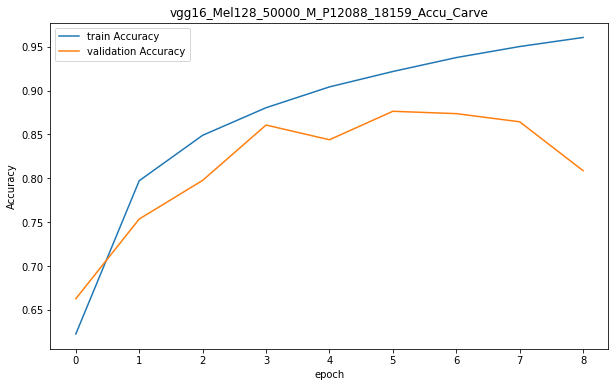

In [35]:
PLot_Model_Results(history,
                   Title=f"{modelName}_Accu_Carve",
                   Acc= True,
                   Saving=True,
                   Path_save=f"{modelName}" )

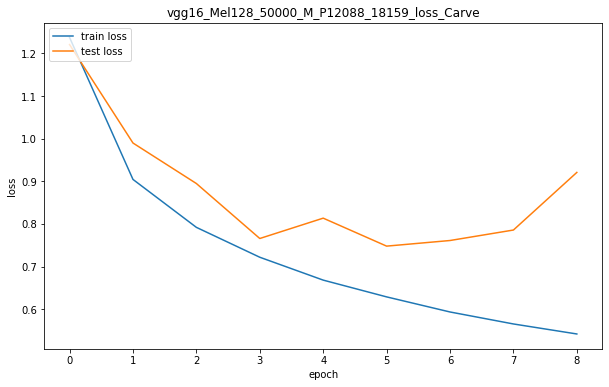

In [36]:
PLot_Model_Results(history,
                   Title=f"{modelName}_loss_Carve",
                   Acc= False,
                   Saving=True,
                   Path_save=f"{modelName}" )

In [37]:
# gih = pd.read_csv("test2.csv",converters={'a': pd.eval})

In [38]:
def Error__anaylsis(model, data_loader):

    # Calcaulte predicted
    preidcted = np.array([])
    with torch.no_grad():
        model.eval()
        test_acc = 0
        for images, labels in test_loader:
            outputs = model(images.to(device))
            _, pred = torch.max(outputs, dim=1)
            preidcted = np.append(preidcted, pred.to("cpu").numpy())

    # Get the True labels, and files names
    indices = data_loader.dataset.indices
    Labels_and_paths = np.array(data_loader.dataset.dataset.imgs)[indices]
    img_paths = Labels_and_paths[:, 0]
    true_labels = Labels_and_paths[:, 1].astype("int")

    # Get classes
    classes = data_loader.dataset.dataset.class_to_idx.keys()

    return preidcted, true_labels, classes, img_paths

In [39]:
preidcted, true_labels, classes, img_paths = Error__anaylsis(model, test_loader)

In [40]:
img_names = [x.split("/")[-1] for x in img_paths]
img_names = [x.split(".")[0] + ".wav" for x in img_names]

In [44]:
import sys
sys.path.append("/kaggle/input/error-analysis/Error_anaysis_f/Error_anaysis_f")  
from Error_Analsis import Error_anaylsis

In [45]:
# source https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report
import matplotlib.pyplot as plt
import numpy as np

class PLot_CR():
    def show_values(self, pc, fmt="%.2f", **kw):
        '''
        Heatmap with text in each cell with matplotlib's pyplot
        Source: https://stackoverflow.com/a/25074150/395857 
        By HYRY
        '''
        pc.update_scalarmappable()
        ax = pc.axes
        #ax = pc.axes# FOR LATEST MATPLOTLIB
        #Use zip BELOW IN PYTHON 3
        for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
            x, y = p.vertices[:-2, :].mean(0)
            if np.all(color[:3] > 0.5):
                color = (0.0, 0.0, 0.0)
            else:
                color = (1.0, 1.0, 1.0)
            ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


    def cm2inch(self, *tupl):
        '''
        Specify figure size in centimeter in matplotlib
        Source: https://stackoverflow.com/a/22787457/395857
        By gns-ank
        '''
        inch = 2.54
        if type(tupl[0]) == tuple:
            return tuple(i/inch for i in tupl[0])
        else:
            return tuple(i/inch for i in tupl)


    def heatmap(self, AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
        '''
        Inspired by:
        - https://stackoverflow.com/a/16124677/395857 
        - https://stackoverflow.com/a/25074150/395857
        '''

        # Plot it out
        fig, ax = plt.subplots()    
        #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
        c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap, vmin=0.0, vmax=1.0)

        # put the major ticks at the middle of each cell
        ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
        ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

        # set tick labels
        #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
        ax.set_xticklabels(xticklabels, minor=False)
        ax.set_yticklabels(yticklabels, minor=False)

        # set title and x/y labels
        plt.title(title, y=1.25)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)      

        # Remove last blank column
        plt.xlim( (0, AUC.shape[1]) )

        # Turn off all the ticks
        ax = plt.gca()    
        for t in ax.xaxis.get_major_ticks():
            t.tick1line.set_visible(False)
            t.tick2line.set_visible(False)
        for t in ax.yaxis.get_major_ticks():
            t.tick1line.set_visible(False)
            t.tick2line.set_visible(False)

        # Add color bar
        plt.colorbar(c)

        # Add text in each cell 
        self.show_values(c)

        # Proper orientation (origin at the top left instead of bottom left)
        if correct_orientation:
            ax.invert_yaxis()
            ax.xaxis.tick_top()       

        # resize 
        fig = plt.gcf()
        #fig.set_size_inches(cm2inch(40, 20))
        #fig.set_size_inches(cm2inch(40*4, 20*4))
        fig.set_size_inches(self.cm2inch(figure_width, figure_height))



    def plot_classification_report(self, classification_report, classes_names, number_of_classes=7, title='Classification report ', cmap='RdYlGn', save_path="", save=False   ):
        '''
        Plot scikit-learn classification report.
        Extension based on https://stackoverflow.com/a/31689645/395857 
        '''
        lines = classification_report.split('\n')
        #drop initial lines
        lines = lines[2:]

        classes = []
        plotMat = []
        support = []
        class_names = []
        for line in lines[: number_of_classes +4 ]:
            t = list(filter(None, line.strip().split('  ')))
            if len(t) < 4: continue
            classes.append(t[0])
            v = [float(x) for x in t[1: len(t)-1]]
            support.append(int(t[-1]))
            class_names.append(t[0])
            plotMat.append(v)

       
        Acuu = list(filter(None, lines[ number_of_classes +1 ].strip().split('  ')))
        class_names.append(f"OVer All accuracy")
        support.append(int(Acuu[2]))
        plotMat.append([0,0, float(Acuu[1])])
        
        xlabel = 'Metrics'
        ylabel = 'Classes'
        xticklabels = ['Precision', 'Recall', 'F1-score']
        yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
        figure_width = 10
        figure_height = len(class_names) + 3
        correct_orientation = True
        self.heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)

        if save == True:
            plt.savefig(f"{save_path}/{title}.jpg",bbox_inches ="tight" )

        plt.show()



        


In [46]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

class Error_anaylsis():
    def __init__(self, y_true, y_pred, classes, PathToSavePLots = "", Df_Path="", file_names= None):
        self.y_true = y_true
        self.y_pred = y_pred
        self.classes = classes
        self.save_path = PathToSavePLots
        self.Df_Path=Df_Path
        self.file_names=file_names
        self.caculted_TF_DF=False
        self.TF_DF= None
    
    def CM(self, plotTitle, Saving=True):
        """Plot the confusion Matrix
            Paramters :

            plotTitle(str): The plot title the diffule "CR"

            Saving(Bool): save the plot in the given path the diffult False
        """
        result = confusion_matrix(self.y_true,  self.y_pred)
        df_cm = pd.DataFrame(result, index = [i for i in self.classes],
                      columns = [i for i in self.classes])
        plt.figure(figsize = (10,7))
        plt.title(plotTitle)
        sns.heatmap(df_cm, annot=True, fmt='g')
        
        if Saving ==True:
            plt.savefig(f"{self.save_path}/{plotTitle}.jpg")
        plt.show()

        
    def CR(self, printing=True, ploting=False, plotTitle="CR", Saving=False ):
        """Calculating the Classification Report and plot it  
        
            Paramters :
            
            printing(Bool): Print the CR the Deffult True
            
            ploting(Bool): Ploting the the CR diffulte False
            
            plotTitle(str): The plot title the diffulte "CR"
            
            Saving(Bool): save the plot in the given path the diffult False
        """
        cr = classification_report(self.y_true,  self.y_pred, target_names=self.classes)
        if printing == True:
            print(cr)
            
        if ploting == True:
            PLot_CR().plot_classification_report(cr, self.classes, 7, title=plotTitle, save = True, save_path=self.save_path )
   
    
    def Create_TF_DF(self):
        if(self.file_names)==None:
            raise Exception("you shouid enter files names in the order of the predictions")
        
        True_OF_False = (self.y_pred == self.y_true).astype(int).tolist()
        self.TF_DF = pd.DataFrame({"filename" : self.file_names, "T_F" : True_OF_False})
        
        Originaldf = pd.read_csv(self.Df_Path)
        Originaldf =  Originaldf[Originaldf["filename"].isin(self.TF_DF["filename"].values)]
        
        self.TF_DF = pd.merge( Originaldf, self.TF_DF, on=["filename"])
        self.caculted_TF_DF =True
        
    
    def All_Length_disPlot(self, PLotTorF=1, plotTitle="Length_disPlot", saveing=False, plotType="kde"):
        """Plot distripution plot for the audios duiorations all for all languages in one figure
        
            PLotTorF(int): get the most speakers the model get them true if it is ==1 or the most flase ==0 diffult ==1
            
            plotTitle(str): The plot title the diffulte "Speakers_disPlot"

            saveing(Bool): save the plot in the given path the diffulte False

            plotType(str): the ploting type for displot {“hist”, “kde”, “ecdf”} the diffulte kde
        """
        
        if self.caculted_TF_DF==False:
            self.Create_TF_DF()
            
        sns.displot(data = self.TF_DF[self.TF_DF.T_F==PLotTorF], x="length", kind=plotType, hue="language" ).set(title=plotTitle)
        if saveing ==True:
            plt.savefig(f"{self.save_path}/{plotTitle}.jpg")
            plt.show()  
            
            
            
            
    def Individually_Length_disPlot(self, PLotTorF=1, plotTitle="Length_disPlot", saveing=False, plotType="kde", langs="All", Train=False):
        """Plot distripution plot for the audios duiorations all for each language in langs in one figure for each language 
        
            PLotTorF(int): get the most speakers the model get them true if it is ==1 or the most flase ==0 diffult ==1
            
            plotTitle(str): The plot title the diffulte "Speakers_disPlot"

            saveing(Bool): save the plot in the given path the diffulte False

            plotType(str): the ploting type for displot {“hist”, “kde”, “ecdf”} the diffulte kde
            
            langs(list): the languages for ploting the diffulte all which wil plot all languages
            
            Train(Bool): Include the train data into the graph or not diffult False
        """
        
        
        if self.caculted_TF_DF==False:
            self.Create_TF_DF()
            
        if langs =="All":
            langs= [lang for lang in self.classes]
            
        if PLotTorF==1:
            Legend_Name= "True Predicted"
        else:
            Legend_Name= "False Predicted"
            
        if Train==True:
            Traindf = pd.read_csv(self.Df_Path)
            
            
        for lang in langs:
            dataPredicted = self.TF_DF[(self.TF_DF.T_F==PLotTorF) & (self.TF_DF.language==lang)]
            dataTest = self.TF_DF[self.TF_DF.language==lang]
            dataTrain = Traindf[Traindf.language==lang]

            if Train==True:
                ax = dataTrain.length.plot(kind = 'density',  alpha = 0.9, color="b", label = "Train", linewidth=2)
                
            ax = dataTest.length.plot(kind = 'density',  alpha = 0.4,color="g", label = 'Test', linewidth=4)
            ax = dataPredicted.length.plot(kind = 'density',  alpha = 0.7, color="r", label = Legend_Name, linewidth=2)

            
            ax.set(xlabel="Length", ylabel="density")
            ax.set(title=f"{plotTitle}_{lang}")
            ax.legend(fontsize=8)
            if saveing ==True:
                plt.savefig(f"{self.save_path}/{plotTitle}_{lang}.jpg")
            plt.show()
            
            
    def All_Speakers_disPlot(self, PLotTorF=1, plotTitle="Speakers_disPlot", saveing=False, Train=False, TopK=5):
        """Plot barPLot figure shows the most Speakers the model get them true of false based on the passed paramters
        
            PLotTorF(int): get the most Speakers the model get them true if it is ==1 or the most flase ==0 diffult ==1
            
            plotTitle(str): The plot title the diffulte "Speakers_disPlot"

            saveing(Bool): save the plot in the given path the diffult False

            Train(Bool): Include the train data into the graph or not diffult False
            
            TopK(int): get the top k speakers diffult 5
            
        """
        
        
        if self.caculted_TF_DF==False:
            self.Create_TF_DF()
            
        if PLotTorF==1:
            Legend_Name= "True Predicted"
            color = "forestgreen"
        else:
            Legend_Name= "False Predicted"
            color = "darkred"
   
        All_Test = self.TF_DF.groupby("speaker")["T_F"].agg("count")
        Predicted = self.TF_DF[self.TF_DF["T_F"]==PLotTorF].groupby("speaker")["T_F"].agg("count").sort_values(ascending=False)[0:TopK]   
        Renamed_Speakrs = [i+1 for i in range(len(Predicted))]
        
        if Train==False:
             # Test
            DF_ = pd.DataFrame(
                     data = { "Renamed_Speakrs": Renamed_Speakrs ,
                         "values" :  All_Test[Predicted.index].values,
                         "type": ["Test"] *len(Predicted[Predicted.index].values) })
            

            # Predicted
            DF_ = pd.concat([DF_ ,
                        pd.DataFrame(data = { "Renamed_Speakrs": Renamed_Speakrs ,
                         "values" : Predicted.values,
                         "type": [Legend_Name] *len(Predicted.values) })])
            
            ax = sns.barplot(data=DF_, x="Renamed_Speakrs", y="values", hue="type",  ci=None, errwidth=0, palette=["gray", color])
            
            ax.bar_label(ax.containers[0])
            ax.bar_label(ax.containers[1])
            ax.set(xlabel="Speaker", ylabel="Count")
            ax.set(title=plotTitle)
            
            
        else:
            Traindf = pd.read_csv(self.Df_Path)
            TrainSPCount = Traindf.groupby("speaker")["speaker"].agg("count")
            
            # Train
            DF_ = pd.DataFrame(
                        data = { "Renamed_Speakrs": Renamed_Speakrs ,
                         "values" : TrainSPCount[Predicted.index].values,
                         "type": ["Train"] *len(TrainSPCount[Predicted.index].values) })
            
            
            # Test
            DF_ = pd.concat([DF_ ,pd.DataFrame(
                        data = { "Renamed_Speakrs": Renamed_Speakrs ,
                         "values" : All_Test[Predicted.index].values,
                         "type": ["Test"] *len(Predicted[Predicted.index].values) })])
            
            
            # Predicted
            DF_ = pd.concat([DF_ ,pd.DataFrame(
                        data = { "Renamed_Speakrs": Renamed_Speakrs ,
                         "values" : Predicted.values,
                         "type": [Legend_Name] *len(Predicted.values) })])
            
            
            ax = sns.barplot(data=DF_, x="Renamed_Speakrs", y="values", hue="type",  ci=None, errwidth=0, palette=["C0", "gray", color])
            ax.bar_label(ax.containers[0])
            ax.bar_label(ax.containers[1])
            ax.bar_label(ax.containers[2])


            ax.set(xlabel="Speaker", ylabel="Count")
            ax.set(title=plotTitle)
        if saveing ==True:
            plt.savefig(f"{self.save_path}/{plotTitle}.jpg")
        plt.show()
        
        
        

    def All_Gender_disPlot(self, PLotTorF=1, plotTitle="Speakers_disPlot", saveing=False, Train=False, Gander="All"):
        """Plot barPLot figure shows the most speakers the model get them true of false based on the passed paramters

            PLotTorF(int): get the most speakers the model get them true if it is ==1 or the most flase ==0 diffult ==1

            plotTitle(str): The plot title the diffulte "Speakers_disPlot"

            saveing(Bool): save the plot in the given path the diffult False

            Train(Bool): Include the train data into the graph or not diffult False
            
            Gander(list): determine the ploted gender diffult value is all == ['n', 'm', 'f']
        """


        if self.caculted_TF_DF==False:
            self.Create_TF_DF()
        if PLotTorF==1:
            Legend_Name= "True Predicted"
            color = "forestgreen"
        else:
            Legend_Name= "False Predicted"
            color = "darkred"
         
        if  Gander=="All":
            Gander =['n', 'm', 'f']
            
            

        All_Test = self.TF_DF.groupby("gender")["T_F"].agg("count")
        Predicted = self.TF_DF[self.TF_DF["T_F"]==PLotTorF].groupby("gender")["T_F"].agg("count").sort_values(ascending=False) 
        Gender_Name = [i for i in Predicted.index]
        
        # PLot Test and Predicted
        if Train==False:
             # Test
            DF_ = pd.DataFrame(
                     data = { "Gender": Gender_Name ,
                         "values" :  All_Test[Predicted.index].values,
                         "type": ["Test"] *len(Predicted[Predicted.index].values) })


            # Predicted
            DF_ = pd.concat([DF_ ,
                        pd.DataFrame(data = { "Gender": Gender_Name ,
                         "values" : Predicted.values,
                         "type": [Legend_Name] *len(Predicted.values) })])

            DF_ = DF_[DF_.Gender.isin(Gander)] 
            print(DF_)
            ax = sns.barplot(data=DF_, x="Gender", y="values", hue="type",  ci=None, errwidth=0, palette=["gray", color])

            ax.bar_label(ax.containers[0])
            ax.bar_label(ax.containers[1])
            ax.set(xlabel="Gender", ylabel="Count")
            ax.set(title=plotTitle)

        # PLot Train, Test and Predicted
        else:
            Traindf = pd.read_csv(self.Df_Path)
            TrainSPCount = Traindf.groupby("gender")["gender"].agg("count")

            # Train
            DF_ = pd.DataFrame(
                        data = { "Gender": Gender_Name ,
                         "values" : TrainSPCount[Predicted.index].values,
                         "type": ["Train"] *len(TrainSPCount[Predicted.index].values) })


            # Test
            DF_ = pd.concat([DF_ ,pd.DataFrame(
                        data = { "Gender": Gender_Name ,
                         "values" : All_Test[Predicted.index].values,
                         "type": ["Test"] *len(Predicted[Predicted.index].values) })])


            # Predicted
            DF_ = pd.concat([DF_ ,pd.DataFrame(
                        data = { "Gender": Gender_Name ,
                         "values" : Predicted.values,
                         "type": [Legend_Name] *len(Predicted.values) })])

            DF_ = DF_[DF_.Gender.isin(Gander)] 
            ax = sns.barplot(data=DF_, x="Gender", y="values", hue="type",  ci=None, errwidth=0, palette=["C0", "gray", color])
            ax.bar_label(ax.containers[0])
            ax.bar_label(ax.containers[1])
            ax.bar_label(ax.containers[2])


            ax.set(xlabel="Gender", ylabel="Count")
            ax.set(title=plotTitle)
        if saveing ==True:
            plt.savefig(f"{self.save_path}/{plotTitle}.jpg")
        plt.show()


In [47]:
# from Error_Analsis import Error_anaylsis as d

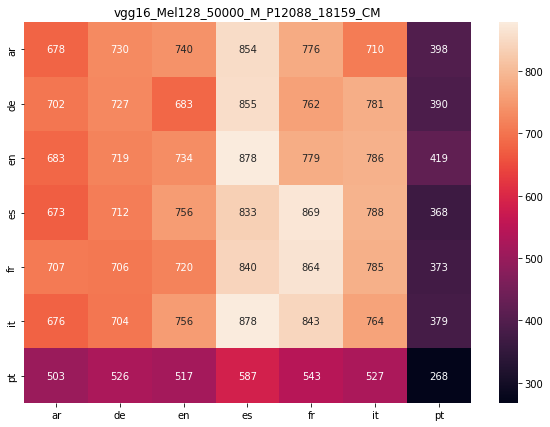

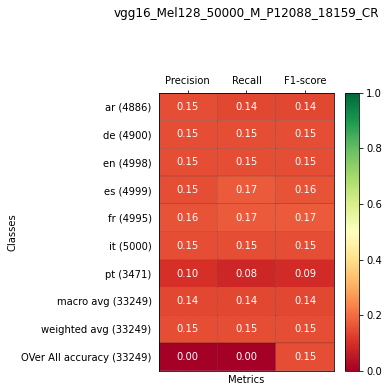

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/melspec35k/sample5000.csv'

In [48]:
EA =Error_anaylsis(
    true_labels,
    preidcted,
    list(classes),
    modelName,
    Df_Path="/kaggle/input/melspec35k/sample5000.csv",
    file_names=img_names,
)
EA.CM(plotTitle=f"{modelName}_CM", Saving=True)
EA.CR(plotTitle=f"{modelName}_CR",printing=False, ploting=True, Saving=True)

EA.All_Speakers_disPlot(PLotTorF=0,  plotTitle=f"{modelName}_AllSpeakers_False", saveing=True, Train=True, TopK=5)
EA.All_Speakers_disPlot(PLotTorF=1,  plotTitle=f"{modelName}_AllSpeakers_True", saveing=True, Train=True, TopK=5)


EA.All_Length_disPlot(PLotTorF=0, plotTitle=f"{modelName}_All_Length_False", saveing=True, plotType="kde")
EA.All_Length_disPlot(PLotTorF=1, plotTitle=f"{modelName}_All_Length_True", saveing=True, plotType="kde")

EA.All_Gender_disPlot(PLotTorF=0,  plotTitle=f"{modelName}_AllSpeakers_False", saveing=True, Train=True, Gander= "All")


EA.Individually_Length_disPlot(
    PLotTorF=0,
    plotTitle="Length_disPlot_False",
    saveing=True,
    plotType="kde",
    langs="All",
    Train=True
)

In [49]:
from IPython.display import FileLink
import shutil

shutil.make_archive(f"{modelName}", 'zip', f"{modelName}")
FileLink(f"{modelName}.zip")


/kaggle/working/vgg16_Mel128_50000_M_P12088_18159.zip

In [50]:
FileLink(f"New_SampledData.csv")

/kaggle/working/New_SampledData.csv

###############################################
##############################################

In [ ]:
model.load_state_dict(torch.load("Plots/vgg16_Mel128_50000_M_P12088_84963/model/vgg16_Mel128_50000_M_P12088_84963.pt"))

# Try 2

In [ ]:
from torch.nn import functional as F
from torch import topk
import cv2

In [ ]:
image = cv2.imread("/kaggle/input/melspec35k/Mel128_5000_M_P_35000/Mel128_5000_M_P_35000/ar/ar-n-525-29596-CV.jpg")
image = cv2.resize(image, (224,224))

height, width, _ = image.shape

transforms = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.Resize((224, 224)),
     transforms.ToTensor()
 
    
    ])

In [ ]:
# https://github.com/zhoubolei/CAM/blob/master/pytorch_CAM.py
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (224, 224)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

In [ ]:
def show_cam(CAMs, width, height, orig_image, class_idx, save_name):
    for i, cam in enumerate(CAMs):
        heatmap = cv2.applyColorMap(cv2.resize(cam,(width, height)), cv2.COLORMAP_JET)
        result = heatmap * 0.3 + orig_image * 0.7
        # put class label text on the result
        cv2.putText(result, str(int(class_idx[i])), (20, 40), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        # cv2.imshow('CAM', result/255.)
        # cv2.waitKey(0)
        cv2.imwrite(f"{modelName}/CAM_{save_name}.jpg", result)

In [ ]:
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())
model._modules.get('features').register_forward_hook(hook_feature)
# get the softmax weight
params = list(model.parameters())
weight_softmax = np.squeeze(params[-2].cpu().data.numpy())

In [ ]:
# apply the image transforms
image_tensor = transforms(image)
# add batch dimension
image_tensor = image_tensor.unsqueeze(0).cuda()
# forward pass through model
outputs = model(image_tensor)
# get the softmax probabilities
probs = F.softmax(outputs).data.squeeze()
# get the class indices of top k probabilities
class_idx = topk(probs, 1)[1].int()

In [ ]:
CAMs = returnCAM(features_blobs[0], weight_softmax, class_idx)

In [ ]:
save_name="Test"
show_cam(CAMs, width, height, image, class_idx, save_name)

# T-Sne Plot for feature

In [ ]:
All_Fe= []
def hook_feature_ForTsne(module, input, output):
    All_Fe.append(output.cpu().numpy())


model._modules.get('features').register_forward_hook(hook_feature_ForTsne)
def Get_Feature_ForTsne(Data_Tesnor, model):
    
    Final_Features = []
    with torch.no_grad():
        model.eval()
        test_acc = 0
        preidcted_Features = np.array([])
        ALL_Labels = np.array([])

        for images, labels in test_loader:
            images = images.cuda()
            labels = labels.to(device)
            outputs = model(images)
            ALL_Labels = np.append(ALL_Labels, labels.to("cpu").numpy())
            Final_Features.extend([x for x  in All_Fe[0][0:images.shape[0]].reshape(-1, All_Fe[0].shape[1] * All_Fe[0].shape[2] * All_Fe[0].shape[3]   )])

        print(ALL_Labels.shape)
        print(len(Final_Features))

    Final_Features = np.array(Final_Features)
    return Final_Features, ALL_Labels
    
    

In [ ]:
Final_Features, ALL_Labels = Get_Feature_ForTsne(test_loader, model)

In [ ]:
from cuml.manifold import TSNE as cu_TSNE
# from sklearn.manifold import TSNE


In [ ]:
cu_X_embedded = cu_TSNE(n_components=2, method="barnes_hut").fit_transform(Final_Features)

In [ ]:
X_embedded = cu_TSNE(n_components=2).fit_transform(Final_Features)

In [ ]:
classes = train_loader.dataset.dataset.class_to_idx.keys()
ALL_Labels_str = [list(classes)[int(i)] for i in ALL_Labels]
tsne_result_df = pd.DataFrame({'tsne_1': X_embedded[:,0], 'tsne_2': X_embedded[:,1], 'label': ALL_Labels_str})

fig,ax = plt.subplots(1, figsize=(10,10))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
lim = (X_embedded.min()-10, X_embedded.max()+10)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.title(f"Tsne plot for {modelName.split('_')[0]} Features")
plt.savefig(f"{modelName}/Feature_Tsne.jpg")
plt.show()

In [ ]:
fig, ax = plt.subplots(1, figsize = (14, 10))
plt.scatter(X_embedded[:,1], X_embedded[:,0], s = 103, c = ALL_Labels, cmap = 'Spectral')
plt.setp(ax, xticks = [], yticks = [])
cbar = plt.colorbar(boundaries = np.arange(11)-0.2)
cbar.set_ticks(np.arange(7))
cbar.set_ticklabels(list(classes))
plt.title('Fashion MNIST Embedded via cumlTSNE');